# Final Project - Probability Distribution Prediction
## Landon Work
## Apr 26, 2023

### Introduction

Uncertainty exists in many situations and quantifying the probability of different
potential outcomes plays an important role in these situations for policymakers.
In some of these situations, there is a clear shape to the probability distribution
or an appropriate distribution based off of some reasonable assumption. For example,
the beta distribution can be used to estimate the *actual* probability of a binary
event, the gamma distribution estimates the time between one event and the next
similar event, and so on.

Many methods of regression even take input features and output the parameters
of the estimated distribution. Loosely defined, this is one way to produce a posterior
distribution $P(Y|X)$. In my work, getting this posterior distribution is
far more useful than getting the population distribution of $Y$.

In my work, however, I encounter situations where there is no known distribution
that adequately represents the variable of interest, such as modeling the
distribution of the price of auction bids. One paper that proposes a solution
to the kinds of problems I face in my job is "Optimizing reserve prices for
publishers in online auctions" by Rhuggenaath et al. (2022). They propose to
discretize the space using cents as the increment and update probabilities for
each price using Bayes' Rule and a custom likelihood function (they call this
technique a "particle filter" but is far different from a traditional genetic
particle filter). One thing that this approach lacks in the information age is
the ability to adapt the distribution based on auction information. We could try
updating a single distribution for each "kind" of auction but the number of features
we can use to describe an auction is in the dozens.  In addition, if we discretize
our space the same as Rhuggenaath et al., the update algorithm would be significantly
slowed by our large range of possible values (we see auction bids of $30+ which
would necessitate 3,000+ weights to update at every step).

Therefore, I set out to solve both problems of managing the number of input
features available and the number of weights which would require updating.
Naturally, I turned to feedforward neural networks because they are capable
of handling many inputs and outputs at once. By passing in all input features,
we remove the need to group/bundle/discretize the domain space which means only
model is needed. And by receiving multiple outputs, we can parameterize the
shape of any distribution we like (such as parameterizing an infinite Gaussian
mixture - see "The infinite Gaussian mixture model" by Rasmussen (2000)).

However, having been inspired by the flexibility of splines and being determined
to explore their utility, I conceived of something which I call a bezier spline
filter. Mixture models such as the infinite Gaussian mixture model had seemed
to me unlikely to work with a neural network architecture because how the parameters
of one distribution changes does not affect the gradient of any other distribution.
Using gradient descent, in my mind, seemed likely to create a mixture consisting
of nearly identical distributions that overlapped. In contrast, the parameters
of the bezier spline filter learn together to describe the entire shape of the
overall distribution rather than the shapes of several individual distributions.

Simply put, doubting the compatibility of neural networks and well known methods
of describing posterior distributions (likely prematurely since I have no experience
with this topic), I jumped the gun and decided to explore something entirely
new and unexplored.

### The Bezier Spline Filter

As I am unclear on what all the exact strengths of bezier spline filter are, I will
begin with a more detailed explanation of what it is and how it works rather
than provide an overview of known uses. There was one general use in mind: describe
$P(Y|X)$.

For example, if $X$ and $Y$ are positively correlated and the variance of $Y$
increases as $X$ increases, we might see real world like the following:

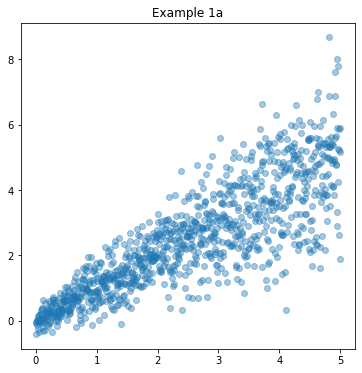

In [24]:
import matplotlib.pyplot as plt
import numpy as np

X = np.linspace(0, 5, 1000)
Y = np.random.normal(X, X / 4 + 0.2)
plt.figure(figsize=(6, 6))
plt.scatter(X, Y, alpha=0.4)
plt.title('Example 1a')
plt.show()

In a situation like this, what we would like to do is have a model that takes
X as input and outputs a distribution describing the mean and variance of Y.

In this case, we know the relationship to be $P(Y|X) \sim N(X, X / 1 + 0.2)$

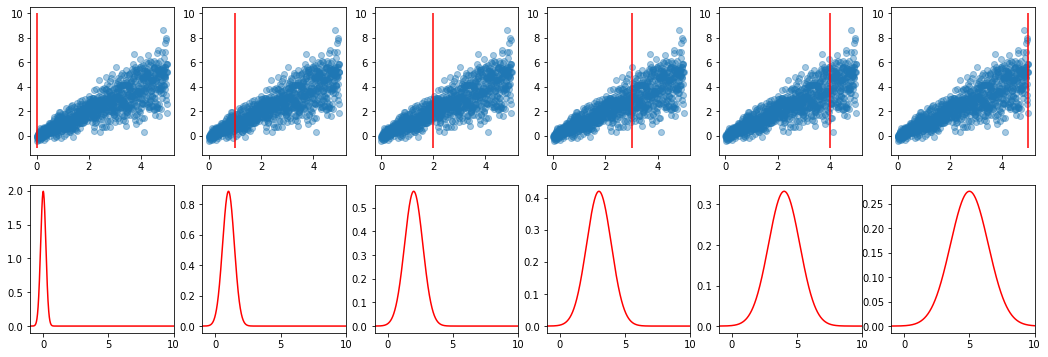

In [25]:
import scipy

fig, axs = plt.subplots(2, 6)
fig.set_figwidth(18)
fig.set_figheight(6)
model = lambda val: (val, val / 4 + 0.2)
for x in range(6):
    # Relate to original plot
    axs[0][x].scatter(X, Y, alpha=0.4)
    axs[0][x].vlines(x, -1, 10, color='red')
    # Get the appropriate posterior distribution given the observed `x`
    mean, var = model(x)
    ys = np.linspace(-1, 10, 1000)
    ps = scipy.stats.norm.pdf(ys, loc=mean, scale=var)
    # Plot the distribution
    axs[1][x].set_xlim(-1, 10)
    axs[1][x].plot(ys, ps, color='red')

Honestly, that was a bit of a detour, but that's the end goal of the bezier spline filter.
This is a simple example, but the hope is for it to learn even more complex distributions.
There are a few things that are required in order for a spline to resemble a
probability distribution. In specific, a bezier spline is a curve that is
interpolated by way of *control points*. Any line segment can by interpolated
by using two points and the fraction of the distance traveled between the two
points. If I take points A: (0, 0) and B: (1, 1) and state that I have traveled
40 percent of the distance from A to B, I know that I am at the point (0.4, 0.4)
by using the linear interpolation $A * (1 - 0.4) + B * 0.4$.

In [26]:
# I am abbreviating linear interpolation to "lerp"
def lerp(a, b, u):
    return a * (1 - u) + b * u

a = np.array([0.0, 0.0])
b = np.array([1.0, 1.0])
u = 0.4
print(f'{u*100:.1f}% between A and B is the point {tuple(lerp(a, b, u))}')

40.0% between A and B is the point (0.4, 0.4)


Now notice that the linear interpolation between points A and B is a valid cumulative
distribution function (CDF). It is the cumulative distribution function for
a uniform distribution which spans the range [0, 1]. Keep this in mind.

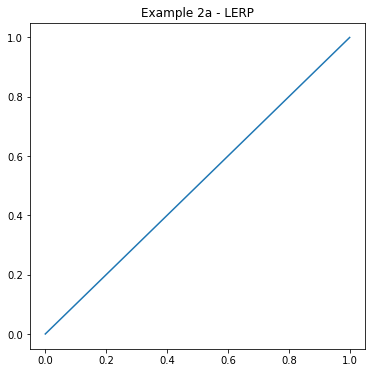

In [27]:
a = np.array([[0.0, 0.0]])
b = np.array([[1.0, 1.0]])
us = np.linspace(0, 1, 1000).reshape((-1, 1))
interp = lerp(a, b, us)

plt.figure(figsize=(6, 6))
plt.plot(interp[:, 0], interp[:, 1])
plt.title('Example 2a - LERP')
plt.show()

Linear interpolation is used to build splines by adding more points and *nesting*
LERP calls. The result of nesting linear interpolations create flexible curves
and are called bezier curves. If we change our set of points from the prior
A and B to the points A: (0, 0), B: (1, 0), C: (1, 1), we can create a curve
that is bowed down and to the right. Notice that the curve is strictly increasing
and defines a valid CDF just as the previous plot does.

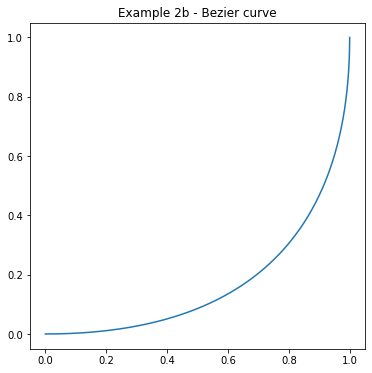

In [28]:
def bezier(a, b, c, u):
    return lerp(lerp(a, b, u), lerp(b, c, u), u)

a = np.array([[0.0, 0.0]])
b = np.array([[1.0, 0.0]])
c = np.array([[1.0, 1.0]])
us = np.linspace(0, 1, 1000).reshape((-1, 1))
interp = bezier(a, b, c, us)

plt.figure(figsize=(6, 6))
plt.plot(interp[:, 0], interp[:, 1])
plt.title('Example 2b - Bezier curve')
plt.show()

We need not discuss any higher-order bezier curves because they cease to be
useful for us after anymore than 3 control points per curve. However, by connecting
bezier curves end-to-end we create what is called a spline, a piece-wise
continuous curve. Many graphics interfaces including typefonts use splines for
drawing smooth curves that have an infinite resolution.

Below is an example of a spline that contains 18 curves and 37 control points.
Because curves are connected end-to-end, there are only $N * 2 + 1$ control points
where $N$ is the number of curves in the spline.

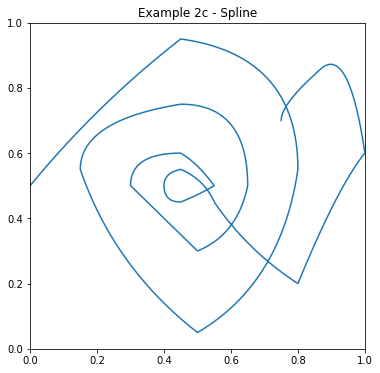

In [29]:
from spline_filter import Spline

points = np.array([
    [0.00, 0.50], [0.20, 0.75], [0.45, 0.95], [0.80, 0.90], [0.80, 0.55], [0.75, 0.20],
    [0.50, 0.05], [0.25, 0.25], [0.15, 0.55], [0.15, 0.70], [0.45, 0.75], [0.65, 0.75],
    [0.65, 0.50], [0.62, 0.35], [0.50, 0.30], [0.40, 0.40], [0.30, 0.50], [0.30, 0.60],
    [0.45, 0.60], [0.50, 0.57], [0.55, 0.50], [0.50, 0.47], [0.45, 0.45], [0.40, 0.45],
    [0.40, 0.50], [0.40, 0.54], [0.45, 0.55], [0.52, 0.52], [0.55, 0.45], [0.65, 0.30],
    [0.80, 0.20], [0.92, 0.5 ], [1.00, 0.60], [0.95, 0.95], [0.86, 0.85], [0.75, 0.75],
    [0.75, 0.70]
])

spline = Spline(points)
plt.figure(figsize=(6, 6))
spline.plot(control_points=False)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Example 2c - Spline')
plt.show()

So with splines, we can draw really complicated curves! But you'll notice that
the curve has very obvious kinks in it where the ends of two bezier curves meet.
This is because the derivatives $dx/du$ and $dy/du$ are not the same. This
can be accomplished by making the middle control points (the B's out of the A's, B's,
and C's) directly opposite each other. Plotting the spline again with the
control points added in will make it obvious that this is not happening in
Example 2c.

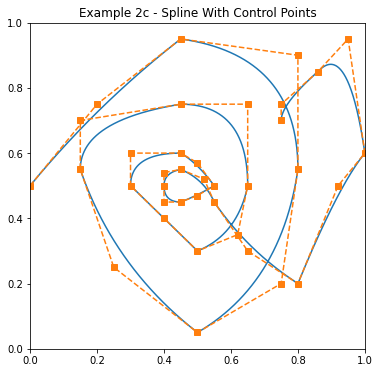

In [30]:
plt.figure(figsize=(6, 6))
spline.plot(control_points=True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Example 2c - Spline With Control Points')
plt.show()

The differentiability of the spline may or may not be useful to the spline filter,
but I decided to enforce a continuous derivative because the derivative ends up
being the probability density function (PDF). So in addition to constructing
a spline directly from control points, a spline can also be constructed from velocities
and start and end points. Like so:


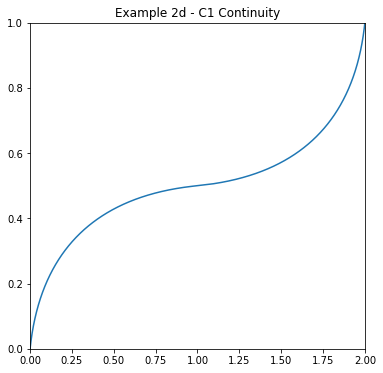

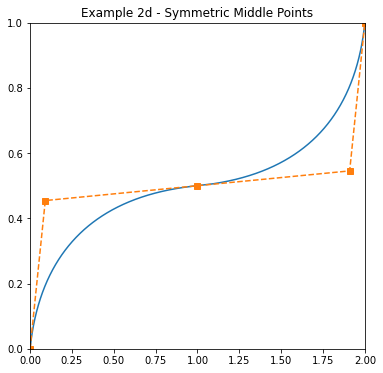

In [31]:
spline = Spline.from_velocities(np.array([
    [0.1, 1.0],
    [1.0, 0.1],
    [0.1, 1.0]
]), end=np.array([2.0, 1.0]))

plt.figure(figsize=(6, 6))
spline.plot(control_points=False)
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.title('Example 2d - C1 Continuity')
plt.show()

plt.figure(figsize=(6, 6))
spline.plot(control_points=True)
plt.xlim(0, 2)
plt.ylim(0, 1)
plt.title('Example 2d - Symmetric Middle Points')
plt.show()

Now we can make pleasing CDFs with continuous PDFs, and we can make them in many
different shapes. And the important part is, we can create a spline with a known
start and end using a small number of parameters. In fact, as long as the velocities 
are positive, we can *always* transform it into a valid CDF by scaling them
by a sort of sum of all the parameters, which is what the `SplineFilter` object
accomplishes.

Now, when we use gradient descent to update the network, all of these parameters
will update collaboratively their sum is used to scale them. If the parameters
represented individual control points instead of velocities, only one curve in
the spline would be updated for each observation.

In the cell below, the `SplineFilter` object is used as the final layer of a feedforward
neural network. The previous layer contains the velocities used to define the
spline and the `SplineFilter` "unfolds" those velocities into the coordinates
for the control points. Those velocities will always define a valid CDF as long
as there is an even number of them that is 4 or greater and all of them are greater
than 0. This is why the last layer uses a sigmoid/softplus activation function.

In [32]:
from tensorflow.keras import Sequential, layers, initializers
from spline_filter import SplineFilter

def new_spline_model(n_curves: int, min: float = 0.0, max: float = 1.0):
    assert n_curves > 0

    model = Sequential([
        layers.Input(1),
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        # The bias initializer is a personal preference. There was a point when it was
        # necessary, but I don't know how to replicate the conditions where that was true
        layers.Dense(16, activation='relu', bias_initializer=initializers.RandomUniform()),
        layers.Dense(n_curves * 2 + 2, activation='sigmoid'),
        SplineFilter(min=min, max=max)
    ])

    return model

Here is a look at the output from a freshly initialized spline filter.

1/1 [==============================] - 0s 71ms/step


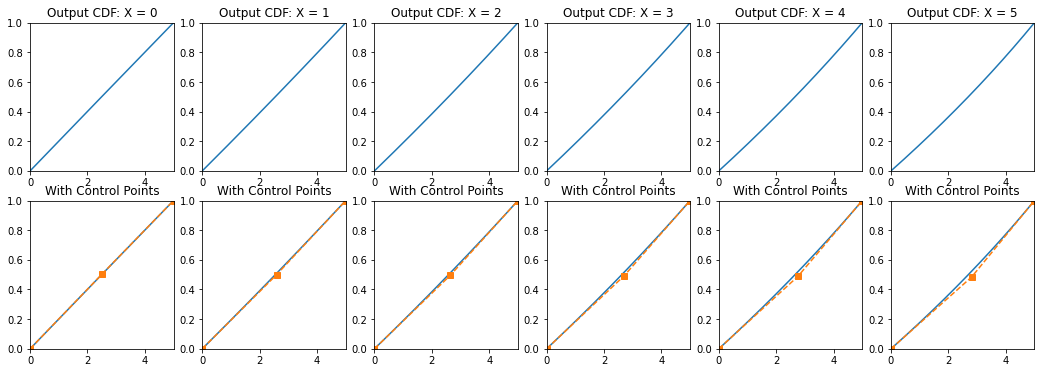

In [33]:
from spline_filter import OneToOneSpline

model = new_spline_model(1, max=5.0)
control_points = model.predict(list(range(6)))
# To make the linear algebra work, the model holds the control points in an unorthodox
# shape. This is how you reshape it.
splines = [OneToOneSpline(control_points[i].reshape((2, -1)).T) for i in range(6)]

fig, axs = plt.subplots(2, 6)
fig.set_figwidth(18)
fig.set_figheight(6)

for i in range(6):
    splines[i].plot(control_points=False, ax=axs[0, i])
    axs[0, i].set_xlim(0, 5)
    axs[0, i].set_ylim(0, 1)
    axs[0, i].set_title(f'Output CDF: X = {i}')

    splines[i].plot(control_points=True, ax=axs[1, i])
    axs[1, i].set_xlim(0, 5)
    axs[1, i].set_ylim(0, 1)
    axs[1, i].set_title(f'With Control Points')

plt.show()

This looks great! It's not doing much yet, but we can see that the output distribution
changes depending on the input which is what we want. This is all good, but what
will help us make more sense of the distribution is the probability density,
and not just the CDF. So let's make sure we can visualize those.

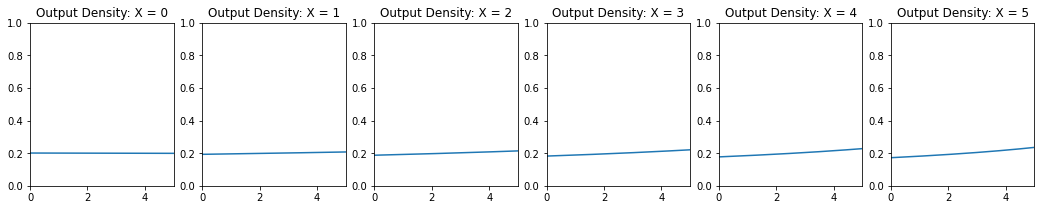

In [34]:
fig, axs = plt.subplots(1, 6)
fig.set_figwidth(18)
fig.set_figheight(3)

for i in range(6):
    splines[i].plot_deriv(ax=axs[i])
    axs[i].set_xlim(0, 5)
    axs[i].set_ylim(0, 1)
    axs[i].set_title(f'Output Density: X = {i}')

plt.show()

### Is It Trainable?

Now we need to see if a model like this is actually trainable. I put a lot of
effort in to make sure it could be trained with data in the same format as
any other model. However, I did have to write a custom loss function. Generally,
distributions are updated by using likelihood functions and the parameters
move in the direction that will maximize said likelihood. However, this requires
some assumption about what the parameters could be, and we are assuming that
we know nothing about the distribution of $Y$ or the parameters. Instead,
the loss I chose was the negative log transform of the probability density.

Using the negative log transform has two benefits. I don't have to have a
likelihood function, and it *heavily* penalizes the model for a distribution
that does not fairly represent uncommon $Y$ values. This latter, for me at least,
is quite important because of the odd noise I see in my company's data. In addition,
from the results I have been able to obtain, this loss function works surprisingly
well for being so naive.

In this section, I will show two different stochastic functions and how the spline
filter is able to fit to the actual distribution.

#### Unimodal to Bimodal

In [58]:
def bimodal_cdf(x, y):
    left  = scipy.stats.norm.cdf(y, loc=10-x, scale=2/(1+x))
    right = scipy.stats.norm.cdf(y, loc=10+x, scale=2/(1+x))
    return (left + right) / 2

def bimodal_pdf(x, y):
    left  = scipy.stats.norm.pdf(y, loc=10-x, scale=2/(1+x))
    right = scipy.stats.norm.pdf(y, loc=10+x, scale=2/(1+x))
    return (left + right) / 2

def generate_bimodal(x): # x ranges from 0 to 5, output ranges from 0 to 20
    left  = lambda : np.clip(np.random.normal(loc=10-x, scale=2/(1+x)), a_min=0, a_max=20)
    right = lambda : np.clip(np.random.normal(loc=10+x, scale=2/(1+x)), a_min=0, a_max=20)
    return np.random.choice([left, right])()

In [59]:
# Generate training data
X = np.linspace(0, 5, 10_000).astype(np.float32)
y = np.array([generate_bimodal(x) for x in X], dtype=np.float32)

In [60]:
from spline_filter import neg_log_spline_density

model = new_spline_model(9, 0, 20)
model.compile(optimizer='adam', loss=neg_log_spline_density)
model.fit(X, y, epochs=50, batch_size=128)

Epoch 1/50
79/79 [==============================] - 2s 11ms/step - loss: 2.7534
Epoch 2/50
79/79 [==============================] - 1s 10ms/step - loss: 2.2805
Epoch 3/50
79/79 [==============================] - 1s 15ms/step - loss: 2.0923
Epoch 4/50
79/79 [==============================] - 1s 15ms/step - loss: 1.9831
Epoch 5/50
79/79 [==============================] - 1s 11ms/step - loss: 1.8534
Epoch 6/50
79/79 [==============================] - 1s 10ms/step - loss: 1.7607
Epoch 7/50
79/79 [==============================] - 1s 10ms/step - loss: 1.6741
Epoch 8/50
79/79 [==============================] - 1s 10ms/step - loss: 1.6566
Epoch 9/50
79/79 [==============================] - 1s 9ms/step - loss: 1.6603
Epoch 10/50
79/79 [==============================] - 1s 10ms/step - loss: 1.6348
Epoch 11/50
79/79 [==============================] - 1s 11ms/step - loss: 1.6342
Epoch 12/50
79/79 [==============================] - 1s 10ms/step - loss: 1.6277
Epoch 13/50
79/79 [===================

1/1 [==============================] - 0s 84ms/step


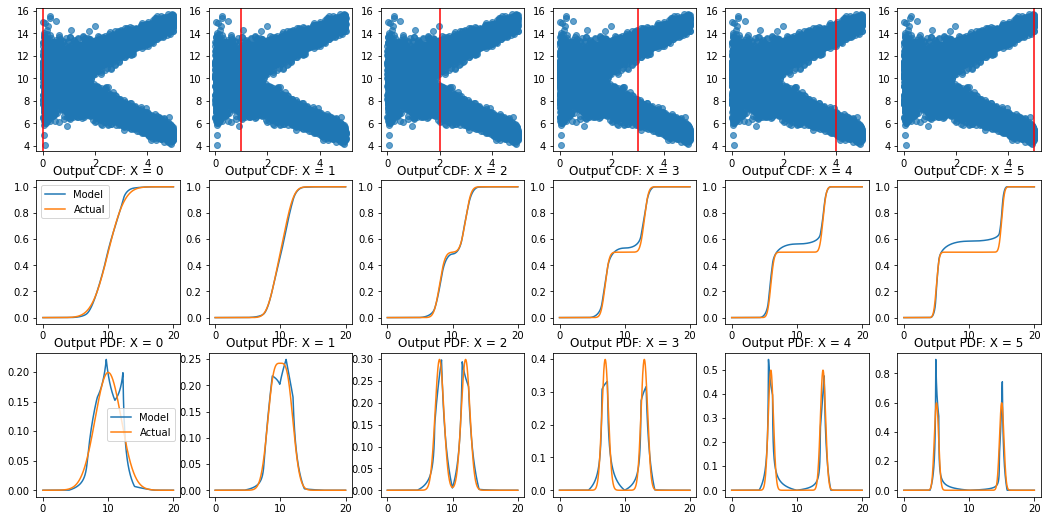

In [61]:
# Get model outputs
dists = model.predict(list(range(6)))
splines = [OneToOneSpline(dists[i].reshape((2, -1)).T) for i in range(6)]

# Get actual distributions
plot_ys = np.linspace(0, 20, 1000)
cdfs = np.array([bimodal_cdf(x, plot_ys) for x in range(6)]).T
pdfs = np.array([bimodal_pdf(x, plot_ys) for x in range(6)]).T

fig, axs = plt.subplots(3, 6)
fig.set_figwidth(18)
fig.set_figheight(9)

for i in range(6):
    axs[0, i].scatter(X, y, alpha=0.7)
    axs[0, i].axvline(i, color='red')

    line = splines[i].plot(control_points=False, ax=axs[1, i])[0]
    actual = axs[1, i].plot(plot_ys, cdfs[:, i])[0]
    axs[1, i].set_title(f'Output CDF: X = {i}')
    if i == 0:
        axs[1, 0].legend([line, actual], ['Model', 'Actual'])

    line = splines[i].plot_deriv(ax=axs[2, i])[0]
    actual = axs[2, i].plot(plot_ys, pdfs[:, i])[0]
    axs[2, i].set_title(f'Output PDF: X = {i}')
    if i == 0:
        axs[2, 0].legend([line, actual], ['Model', 'Actual'])

plt.show()

#### Cyclical Discontinuous Density

In [62]:
def discontinuous_cdf(descriptor, y):
    d = 2 * descriptor
    if d >= 5.0:
        if y < 10.0 - d:
            return  y * 0.1
        elif y < 15.0 - d:
            return (10 - d) * 0.1
        elif y < 20.0 - d:
            return y * 0.1 - 0.5
        elif y < 25.0 - d:
            return (15 - d) * 0.1
        elif y < 30.0 - d:
            return y * 0.1 - 1.0
        else:
            return 1.0
    else:
        if y < 5.0 - d:
            return 0.0
        elif y < 10.0 - d:
            return  (y + d - 5) * 0.1
        elif y < 15.0 - d:
            return 0.5
        elif y < 20.0 - d:
            return (y + d - 10) * 0.1    
        else:
            return 1.0

def discontinuous_pdf(descriptor, y):
    if ((y + 2 * descriptor) // 5) % 2 == 1:
        return 0.1
    else:
        return 0.0

def generate_discontinuous(descriptor): # descriptor ranges from 0 to 5, output ranges from 0 to 20
    y = np.random.uniform(5, 15)
    if y >= 10.0:
        y += 5.0
    y -= 2 * descriptor
    if y < 0:
        y += 20
    return y

In [63]:
X = np.random.uniform(0, 5, size=10_000).astype(np.float32)
y = np.array([generate_discontinuous(x) for x in X], dtype=np.float32)

In [64]:
model = new_spline_model(9, 0, 20)
model.compile(optimizer='adam', loss=neg_log_spline_density)
model.fit(X, y, epochs=50, batch_size=128)

Epoch 1/50
79/79 [==============================] - 1s 10ms/step - loss: 2.9771
Epoch 2/50
79/79 [==============================] - 1s 10ms/step - loss: 2.9015
Epoch 3/50
79/79 [==============================] - 1s 9ms/step - loss: 2.7884
Epoch 4/50
79/79 [==============================] - 1s 10ms/step - loss: 2.7112
Epoch 5/50
79/79 [==============================] - 1s 10ms/step - loss: 2.6648
Epoch 6/50
79/79 [==============================] - 1s 10ms/step - loss: 2.6126
Epoch 7/50
79/79 [==============================] - 1s 10ms/step - loss: 2.5830
Epoch 8/50
79/79 [==============================] - 1s 11ms/step - loss: 2.5615
Epoch 9/50
79/79 [==============================] - 1s 10ms/step - loss: 2.5445
Epoch 10/50
79/79 [==============================] - 1s 10ms/step - loss: 2.5303
Epoch 11/50
79/79 [==============================] - 1s 10ms/step - loss: 2.5166
Epoch 12/50
79/79 [==============================] - 1s 10ms/step - loss: 2.5064
Epoch 13/50
79/79 [===================

1/1 [==============================] - 0s 73ms/step


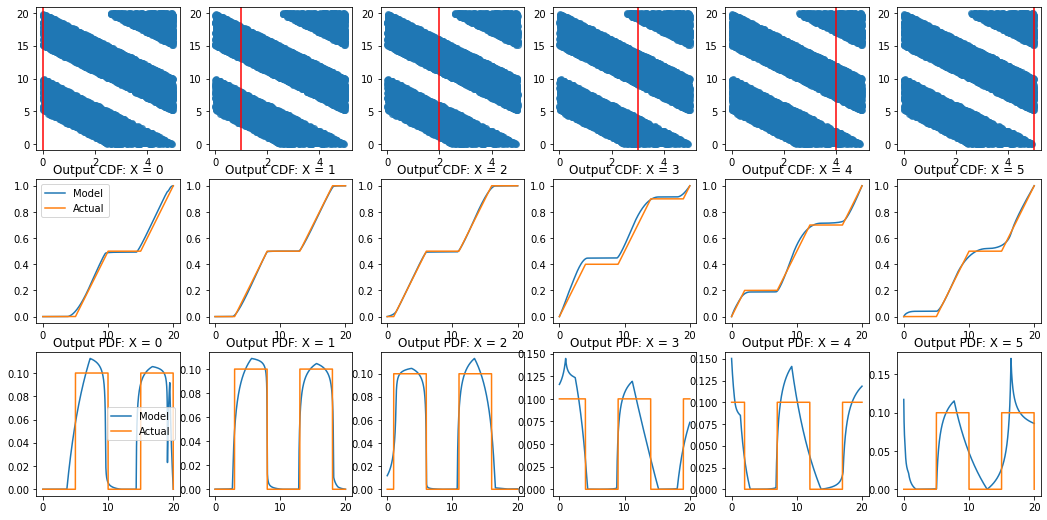

In [65]:
# Get model outputs
dists = model.predict(list(range(6)))
splines = [OneToOneSpline(dists[i].reshape((2, -1)).T) for i in range(6)]

# Get actual distributions
plot_ys = np.linspace(0, 20, 1000)
cdfs = np.array([[discontinuous_cdf(x, plot_y) for plot_y in plot_ys] for x in range(6)]).T
pdfs = np.array([[discontinuous_pdf(x, plot_y) for plot_y in plot_ys] for x in range(6)]).T

fig, axs = plt.subplots(3, 6)
fig.set_figwidth(18)
fig.set_figheight(9)

for i in range(6):
    axs[0, i].scatter(X, y, alpha=0.7)
    axs[0, i].axvline(i, color='red')

    line = splines[i].plot(control_points=False, ax=axs[1, i])[0]
    actual = axs[1, i].plot(plot_ys, cdfs[:, i])[0]
    axs[1, i].set_title(f'Output CDF: X = {i}')
    if i == 0:
        axs[1, 0].legend([line, actual], ['Model', 'Actual'])

    line = splines[i].plot_deriv(ax=axs[2, i])[0]
    actual = axs[2, i].plot(plot_ys, pdfs[:, i])[0]
    axs[2, i].set_title(f'Output PDF: X = {i}')
    if i == 0:
        axs[2, 0].legend([line, actual], ['Model', 'Actual'])

plt.show()

## Conclusion

The spline filter, at least in this miniature experiment, adapts to very unorthodox
distributions that are dependent on an input feature. There are some limitations.
It only works for 1-D outputs. Perhaps something similar could be applied with
a mesh for a 2-D output or a joint conditional distribution. In addition, I'm
not entirely sure that the training is parallelizable, and currently there is
not way to get an expected value or to sample the distribution easily, both
uses that are extremely useful to Bayesian analysis.

There may be many other flaws with this idea for filtration or it may turn out,
if someone much better at mathematics than me were to devote the time, that
there are ways around the problems with this initial implementation. Either way,
this was an exciting project and one that I will likely share with the world
through a public [repository](https://github.com/landonwork/spline_filter).